This notebook 

In [7]:
#import packages and initialize settings
import os
import numpy as np
from astropy.io import fits
import astropy.io.fits as pyfits
from astropy.wcs import WCS
from matplotlib import pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table
from astropy.io import ascii
from reproject import reproject_interp

plt.rc('text',usetex=True)
fontsize=20
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']="white"

import sys
sys.path.append('/home/mayker.1/Desktop/PythonFunctions')

In [8]:
# Get SNeCO information
database = Table.read('../Data/3.SNe+GalData.csv', format = "csv")

database[0:1]

galaxy,SN_name,SN_type,SN_ra,SN_dec,SN_xCoord,SN_yCoord,SN_co21int,SN_co21err,SN_co21ew,map_beamsize,orient_ra,orient_dec,dist,orient_posang,orient_incl,size_r25,telOrient,ImageFile150,ErrFile150,AlphaCOFile
str8,str11,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9,str112,str113,str74
circinus,SN1996cr,II,213.2918,-65.3457,86.56761411031889,84.63433198287285,186.84804,2.137819,34.56537,0.002032163908078,213.29124,-65.33915,4.2,36.74,64.3,262.49515,7m+tp,/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/circinus/circinus_7m+tp_co21_150pc_broad_mom0.fits,/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/circinus/circinus_7m+tp_co21_150pc_broad_emom0.fits,/data/kant/0/sun.1608/PHANGS/ALMA/alphaCO/ESO097-013_alphaCO21_Sun+20.fits


<ipython-input-9-ad8bedd466b1>:11: RuntimeWarning: invalid value encountered in log10
  logmap = np.log10(map)


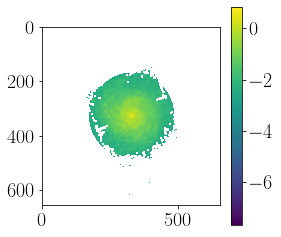

In [9]:
galaxies = np.array(database["galaxy"], dtype='object')   
SNe, SNra, SNdec  = np.array(database["SN_name"], dtype='object'), np.array(database["SN_ra"], dtype='object'), np.array(database["SN_dec"], dtype='object')
telOrient = np.array(database["telOrient"], dtype='object')
centerCoords = [(database["orient_ra"][i], database["orient_dec"][i]) for i in range(len(database))] 

#fileName = "/data/tycho/0/leroy.42/projects/phangs_survey_2019/working_data/irac/ngc0628_irac1_1kpc.fits"
fileName = "/data/tycho/0/leroy.42/projects/phangs_survey_2019/working_data/irac/ngc0628_irac1_gauss7p5.fits"
hdulist = pyfits.open(fileName)
map = hdulist[0].data
#wcs = WCS(hdulist[0].header, naxis=2)
logmap = np.log10(map)
plt.figure(figsize = (4,4))
plt.imshow(logmap, cmap='viridis')
plt.colorbar()


In [10]:
# generate list of galaxies in IRAC sample and Phangs Alma coverage maps
# "/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/" + galaxy + "_12m+7m+tp_co21_150pc_coverage2d.fits"

IRFileList, PACovFileList = [],[]

for i in range(len(galaxies)):
    PACovFileList.append("/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/" + galaxies[i] + "/" + galaxies[i] + "_" + telOrient[i] + "_co21_150pc_coverage2d.fits")
    if galaxies[i] == "circinus":
        galaxies[i] = "eso097-013"
    fileCheck = "/data/tycho/0/leroy.42/projects/phangs_survey_2019/working_data/irac/" + galaxies[i] + "_irac1_gauss7p5.fits"
    if os.path.isfile(fileCheck) == False:
        fileCheck = "/data/tycho/0/leroy.42/projects/phangs_survey_2019/working_data/z0mgs/" + galaxies[i] + "_w1_gauss7p5.fits"
        if os.path.isfile(fileCheck) == False:
            fileCheck = "No IRAC or WISE File for " + galaxies[i] + "."        
    else: pass
    IRFileList.append(fileCheck)

    

In [11]:
# for i in range(len(fileList)):
#     print(fileList[i])

database.add_column(PACovFileList, name ="PACovFile")
database.add_column(IRFileList, name = "IFRFile")

database[0:1]

galaxy,SN_name,SN_type,SN_ra,SN_dec,SN_xCoord,SN_yCoord,SN_co21int,SN_co21err,SN_co21ew,map_beamsize,orient_ra,orient_dec,dist,orient_posang,orient_incl,size_r25,telOrient,ImageFile150,ErrFile150,AlphaCOFile,PACovFile,IFRFile
str8,str11,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9,str112,str113,str74,str112,str97
circinus,SN1996cr,II,213.2918,-65.3457,86.56761411031889,84.63433198287285,186.84804,2.137819,34.56537,0.002032163908078,213.29124,-65.33915,4.2,36.74,64.3,262.49515,7m+tp,/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/circinus/circinus_7m+tp_co21_150pc_broad_mom0.fits,/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/circinus/circinus_7m+tp_co21_150pc_broad_emom0.fits,/data/kant/0/sun.1608/PHANGS/ALMA/alphaCO/ESO097-013_alphaCO21_Sun+20.fits,/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/circinus/circinus_7m+tp_co21_150pc_coverage2d.fits,/data/tycho/0/leroy.42/projects/phangs_survey_2019/working_data/z0mgs/eso097-013_w1_gauss7p5.fits


Missing IRAC files for Circinus, NGC2997, NGC4945, NGC5128, NGC5530, NGC6744
Wise files available in ZOMGS directory
Missing 150pc res and coverage files for NGC 1068, 1672, & 4579
for now will leave out and maybe revisit with another resolution later?

What resolution is this map: 7p5 arcsec
W1 wise is 3.4 microns.
"IRAC is a four-channel camera that provides simultaneous 5.2 x 5.2 arcmin images at 3.6, 4.5, 5.8, and 8 microns (the black instrument in the lower right part of the above image; see the optical housing model and the conceptual layout diagram. The pixel size is 1.22 arcsec in all bands. "

In [ ]:
# remove duplicate galaxies, grouping SNe together in their own lists.

gal_group = database.group_by("galaxy")

SNr, SNd, SNa = [],[],[]
gala, ifrs, covs, imgs, errs, alco, cocs, pans, incl, gdis, SNrs, SNdc, SNea = [],[],[],[],[],[],[],[],[],[],[],[],[]

for i in range(len(database)):
    gal = database["galaxy"][i]
    ifr = database["IFRFile"][i]
    cov = database["PACovFile"][i]
    img = database["ImageFile150"][i]
    ers = database["ErrFile150"][i]
    aco = database["AlphaCOFile"][i]
    ccs = centerCoords[i]
    pas = database["orient_posang"][i]
    inc = database["orient_incl"][i]
    gds = database["dist"][i]
    SNr.append(SNra[i])
    SNd.append(SNdec[i])
    SNa.append(SNe[i])
    
    if (i+1) in gal_group.groups.indices:
        #print(gal)
        if gal != "ngc1068" and gal != "ngc1672" and gal != "ngc4579":
            #print(gal)
            gala.append(gal)
            ifrs.append(ifr)
            covs.append(cov)
            imgs.append(img)
            errs.append(ers)
            alco.append(aco)
            cocs.append(ccs)
            pans.append(pas)
            incl.append(inc)
            gdis.append(gds)
            SNrs.append(SNr)
            SNdc.append(SNd)
            SNea.append(SNa) 
            SNr, SNd, SNa = [],[],[]
        else: pass
    else: pass

<ipython-input-26-280115d7ef1e>:56: RuntimeWarning: divide by zero encountered in log10
  logCovMap, logIfrMap = np.log10(covMap), np.log10(ifrMap)
<ipython-input-26-280115d7ef1e>:56: RuntimeWarning: invalid value encountered in log10
  logCovMap, logIfrMap = np.log10(covMap), np.log10(ifrMap)


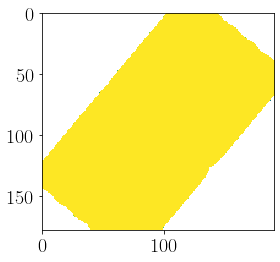

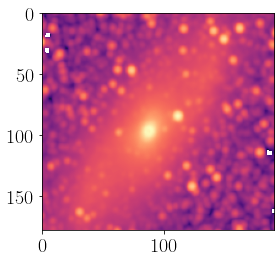

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


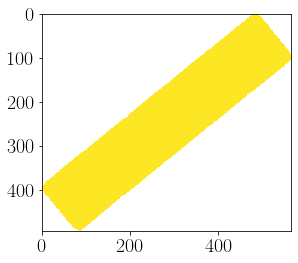

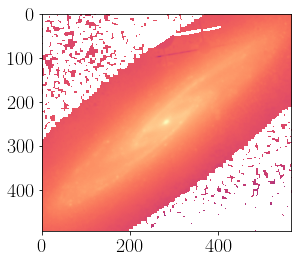

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


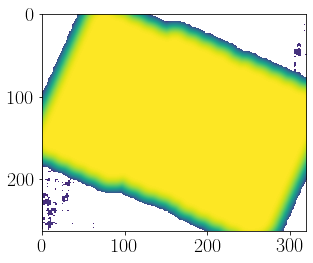

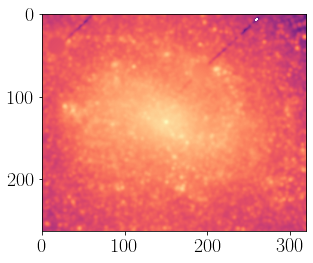

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


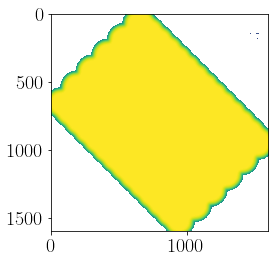

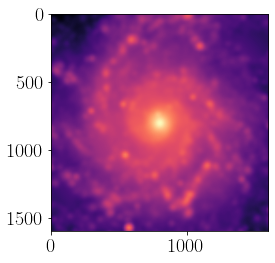

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


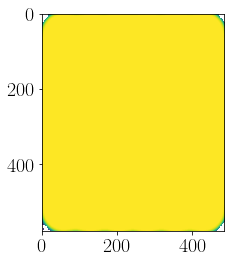

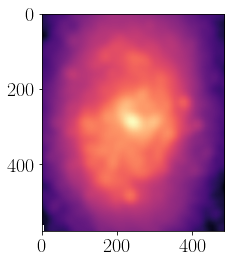

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


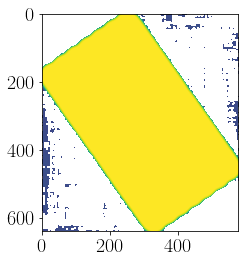

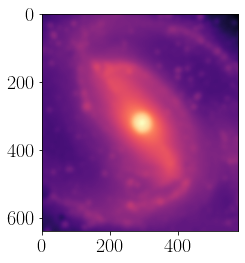

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


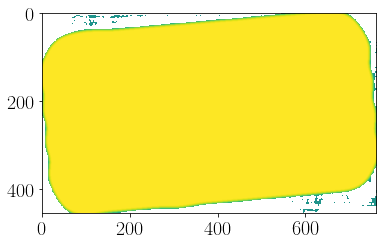

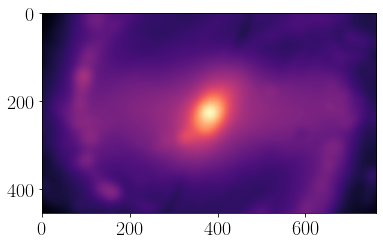

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


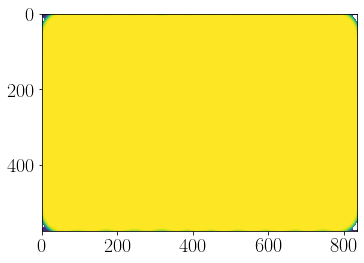

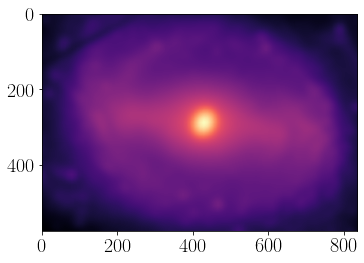

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


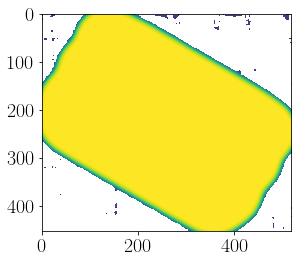

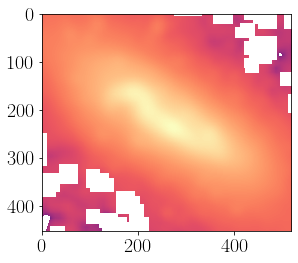

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


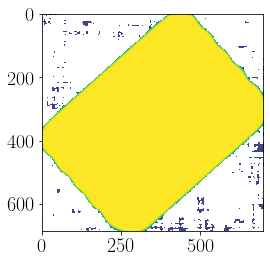

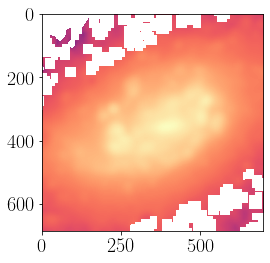

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


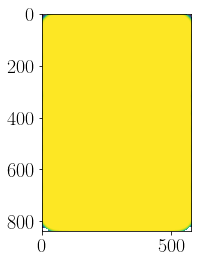

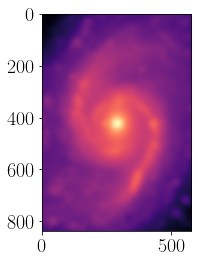

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


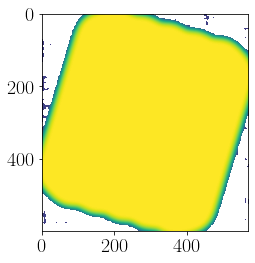

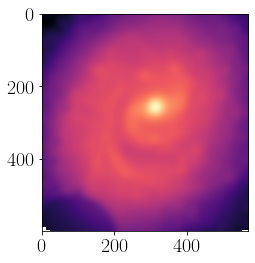

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


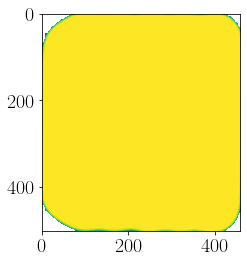

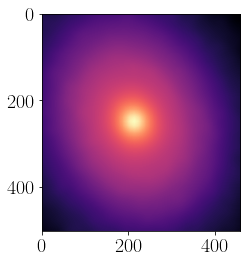

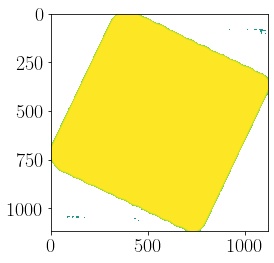

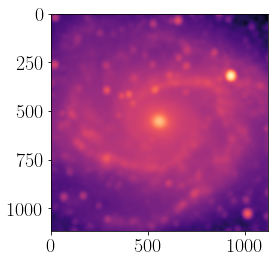

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


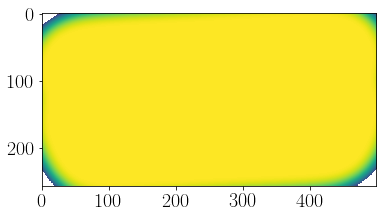

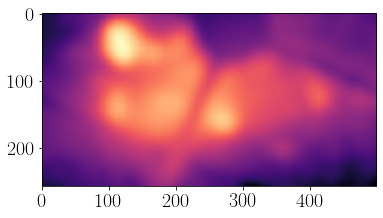

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


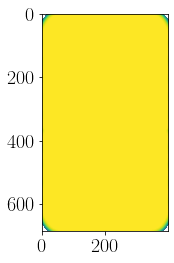

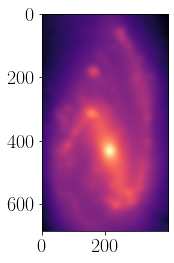

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


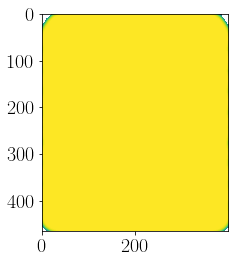

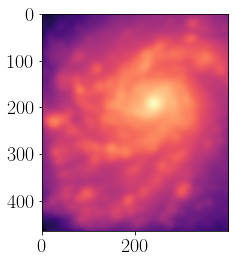

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


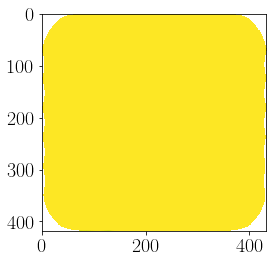

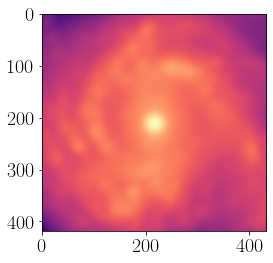

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


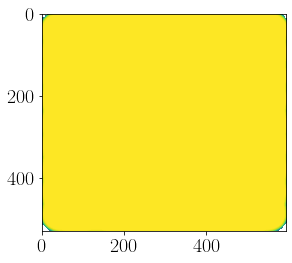

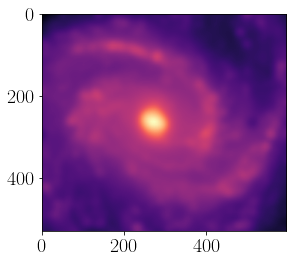

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


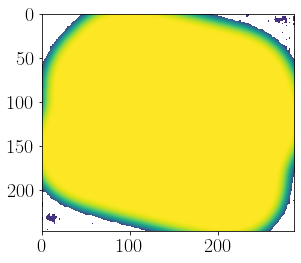

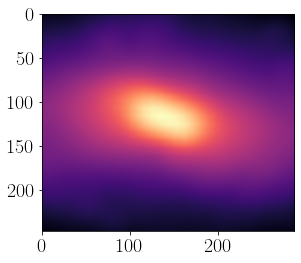

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


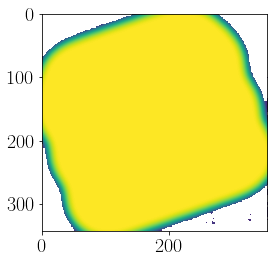

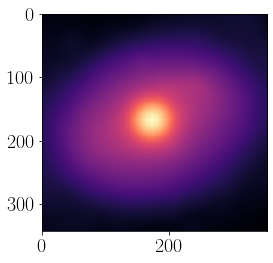

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


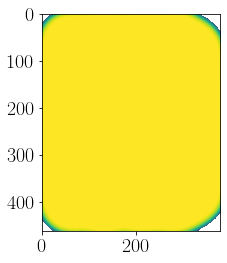

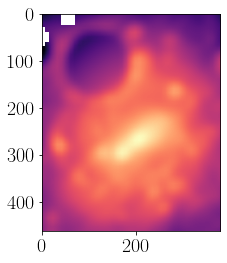

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


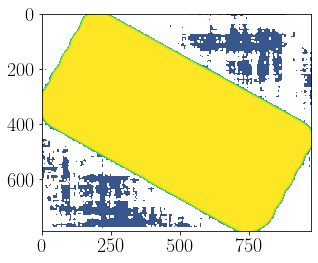

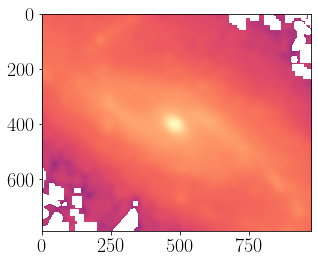

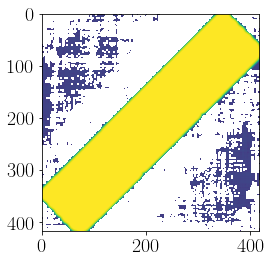

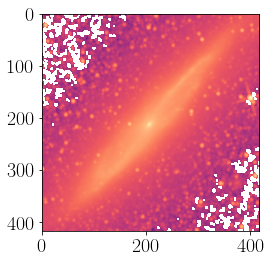

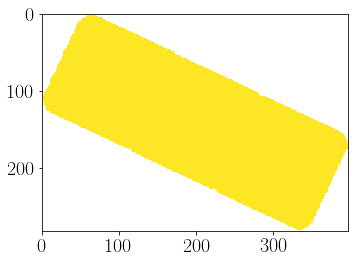

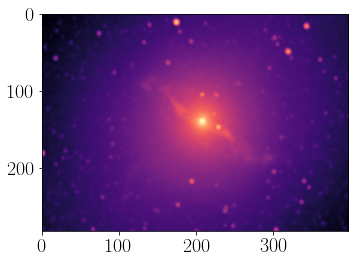

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


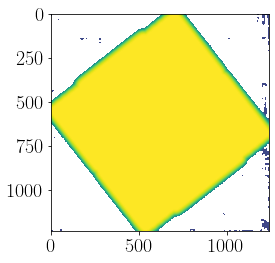

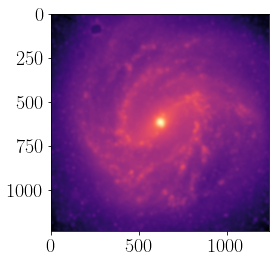

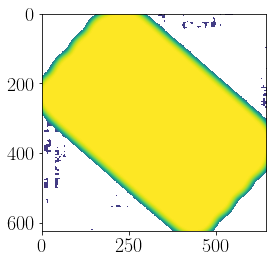

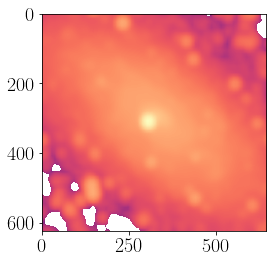

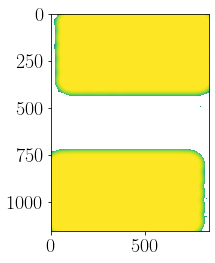

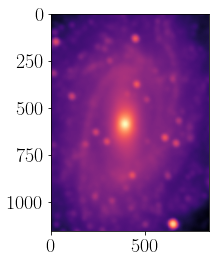

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


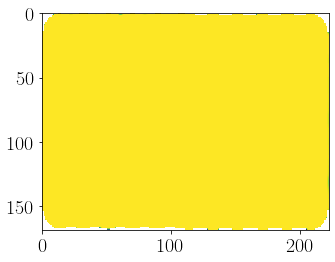

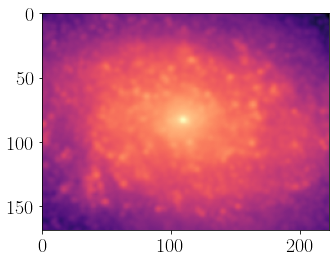

In [26]:
# Next apply clipping to match field of coverage
# use reproject_interp and project IRAC onto the PHANGS one and keep the overlap coverage as the locations that 
# the SNe can occur in 

# gala, ifrs, covs, imgs, errs, alco, cocs, pans, incl, gdis, SNrs, SNdc, SNea

#for i in range(len(gala)):
for i in range(1):
    
    covFile = covs[i]
    ifrFile = ifrs[i]
    hdu_cov = pyfits.open(covFile)
    hdu_ifr = pyfits.open(ifrFile)
    covMap  = hdu_cov[0].data
    ifrMap, footprint = reproject_interp(hdu_ifr, hdu_cov[0].header)
        
    wcs     = WCS(hdu_ifr[0].header, naxis=2)
    naxis   = wcs._naxis # size of image naxis[0] = x and [1] = y
    grid    = np.indices((naxis[1],naxis[0]))
    ra, dec = wcs.wcs_pix2world(grid[1],grid[0],0)   
    
    f_cov = covMap.flatten()
    f_ifr = ifrMap.flatten()  
    f_ra  = ra.flatten()
    f_dec = dec.flatten()
    
    keep = np.where(f_cov > 0.9)
    ifr  = f_ifr[keep]
    ra   = f_ra[keep]
    dec  = f_dec[keep]
    
    
    
    

In [ ]:
!bug

In [ ]:
#from FindNearestMC import findNearest

# def findNearest(x1,x2,y1,y2):
#     return(mindist) 

# if this uses too much memory, play minesweeper, 0 for gas and grow
# scipy scikit-image

# or monte carlo and only do numpy random choice to pick weigheted probability choice from the probability arrays 
# and then do like 10,000 draws from that array before feeding into the pair_dist_calc


# can imshow the matricies 
# print the shapes of the tile columns, etc
